In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

DATA_DIR = ''
BUFFER = 32
Z_DIM = 20
Z_START = 16

BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device('cuda:0')
torch.cuda.empty_cache()

In [2]:
def load(split, index, name):
    img = torch.from_numpy(np.array(Image.open(f'{split}/{index}/{name}.png'))).gt(0).float().to(DEVICE)
    return img

mask_test_a = load('test', 'a', 'mask')
mask_test_b = load('test', 'b', 'mask')

mask_train_1 = load('train', '1', 'mask')
labels_train_1 = load('train', '1', 'inklabels')

mask_train_2 = load('train', '2', 'mask')
labels_train_2 = load('train', '2', 'inklabels')

mask_train_3 = load('train', '3', 'mask')
labels_train_3 = load('train', '3', 'inklabels')

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2: {mask_train_2.shape}")
print(f"labels_train_2: {labels_train_2.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")

D:\anaconda\Lib\site-packages\PIL\Image.py:3157: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


mask_test_a: torch.Size([2727, 6330])
mask_test_b: torch.Size([5454, 6330])
-
mask_train_1: torch.Size([8181, 6330])
labels_train_1: torch.Size([8181, 6330])
-
mask_train_2: torch.Size([14830, 9506])
labels_train_2: torch.Size([14830, 9506])
-
mask_train_3: torch.Size([7606, 5249])
labels_train_3: torch.Size([7606, 5249])


In [3]:
def load_volume(split, index):
    # Load the 3d x-ray scan, one slice at a time
    z_slices_fnames = sorted(glob.glob(f"{split}/{index}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]
    z_slices = []
    
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = Image.open(filename)
        z_slice = torch.from_numpy(np.array(img, dtype="float32"))
        z_slices.append(z_slice)
        
    img_stack = torch.stack(z_slices, dim=-1).to(DEVICE)
    return img_stack

volume_train_1 = load_volume(split="train", index=1)
print(f"volume_train_1: {volume_train_1.shape}, {volume_train_1.dtype}")
"""
volume_train_2 = load_volume(split="train", index=2)
print(f"volume_train_2: {volume_train_2.shape}, {volume_train_2.dtype}")

volume_train_3 = load_volume(split="train", index=3)
print(f"volume_train_3: {volume_train_3.shape}, {volume_train_3.dtype}")

volume = torch.concat([volume_train_1, volume_train_2, volume_train_3], axis=1)
print(f"total volume: {volume.shape}")

del volume_train_1
del volume_train_2
del volume_train_3
"""

20it [00:07,  2.63it/s]


volume_train_1: torch.Size([8181, 6330, 20]), torch.float32


'\nvolume_train_2 = load_volume(split="train", index=2)\nprint(f"volume_train_2: {volume_train_2.shape}, {volume_train_2.dtype}")\n\nvolume_train_3 = load_volume(split="train", index=3)\nprint(f"volume_train_3: {volume_train_3.shape}, {volume_train_3.dtype}")\n\nvolume = torch.concat([volume_train_1, volume_train_2, volume_train_3], axis=1)\nprint(f"total volume: {volume.shape}")\n\ndel volume_train_1\ndel volume_train_2\ndel volume_train_3\n'

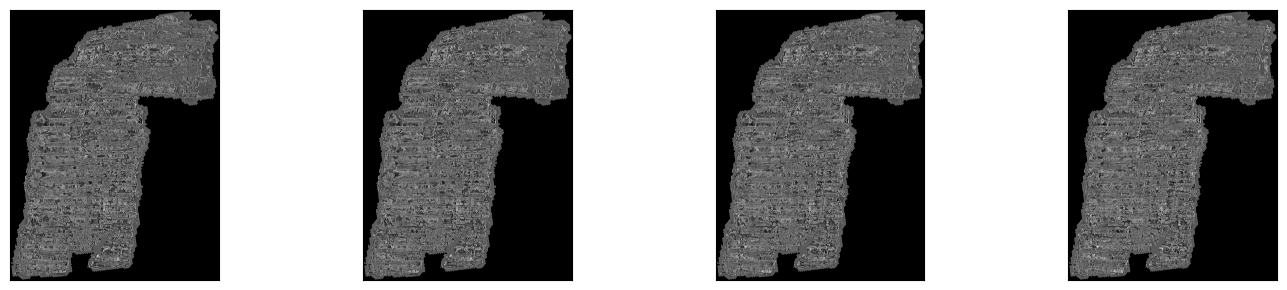

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for z, ax in enumerate(axes):
    ax.imshow(volume_train_1[:, :, z].cpu(), cmap='gray')
    ax.set_xticks([]); ax.set_yticks([])
    
fig.tight_layout()
plt.show()

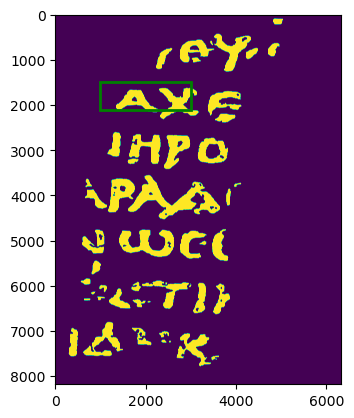

In [5]:
val_location = ([1500, 1000])
val_zone_size = ([600, 2000])

fig, ax = plt.subplots()
ax.imshow(labels_train_1.cpu())
patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(patch)
plt.show()

In [6]:
def sample_random_location(shape):
    random_train_x = torch.randint(low=BUFFER, high=shape[0]-BUFFER-1, size=(1, ), dtype=torch.int32)
    random_train_y = torch.randint(low=BUFFER, high=shape[1]-BUFFER-1, size=(1, ), dtype=torch.int32)
    randon_train_location = torch.stack([random_train_x, random_train_y])
    return randon_train_location

def is_in_mask_zone(location, mask):
    return mask[location[0], location[1]]

def is_in_val_zone(location, val_location, val_zone_size):
    x = location[0]
    y = location[1]
    x_match = (val_location[0]-BUFFER <= x <= val_location[0]+val_zone_size[0]-BUFFER)
    y_match = (val_location[1]-BUFFER <= y <= val_location[1]+val_zone_size[1]-BUFFER)
    return x_match and y_match

def is_proper_train_location(location, val_location, val_zone_size, mask):
    return not is_in_val_zone(location, val_location, val_zone_size) and is_in_mask_zone(location, mask)

sample_train_location_train = lambda x: sample_random_location(mask_train_1.shape)
train_location_list = [sample_train_location_train(0) for _ in range(100)]
train_location_tensor = torch.stack(train_location_list)
train_location_ds = torch.utils.data.TensorDataset(train_location_tensor)
train_location_loader = torch.utils.data.DataLoader(train_location_ds, batch_size=1)
proper_train_location = []
for location in train_location_loader:
    location = location[0]
    location = location.squeeze()
    if is_proper_train_location(location, val_location, val_zone_size, mask_train_1):
        proper_train_location.append(location)
        
proper_train_location_tensor = torch.stack(proper_train_location)

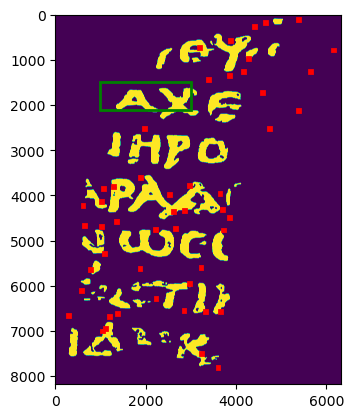

In [7]:
fig, ax = plt.subplots()
ax.imshow(labels_train_1.cpu())

for x, y in proper_train_location_tensor.cpu():
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

val_patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(val_patch)
plt.show()

In [24]:
import torch
from torch.utils.data import DataLoader, TensorDataset

BUFFER = 5  # Assuming BUFFER value; adjust as needed
BATCH_SIZE = 32  # Assuming BATCH_SIZE value; adjust as needed

def extract_subvolume(location, volume):
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :]
    subvolume = torch.tensor(subvolume, dtype=torch.float32) / 65535.
    return subvolume.permute(2, 0, 1)  # Adjust dimensions for PyTorch (channels first)

def extract_labels(location, labels):
    x = location[0]
    y = location[1]
    label = labels[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER]
    label = torch.tensor(label, dtype=torch.float32)
    label = label.unsqueeze(dim=-1)
    return label.permute(2, 0, 1)  # Adjust dimensions for PyTorch (channels first)

def extract_subvolume_and_label(location):
    subvolume = extract_subvolume(location, volume_train_1)
    label = extract_labels(location, labels_train_1)
    return subvolume, label

# Assuming train_locations_ds is a list of locations
train_tensor_locations = torch.tensor(proper_train_location_tensor, dtype=torch.int64)
train_tensor_labels = torch.tensor(labels_train_1, dtype=torch.float32)  # Assuming labels is your label data

train_dataset = TensorDataset(train_tensor_locations)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Assuming volume is your 3D volume data
# You may need to adjust the data types and dimensions based on your actual data format
for batch in train_loader:
    locations = batch[0]
    subvolume_batch = torch.stack([extract_subvolume(location.tolist(), volume_train_1) for location in locations])
    label_batch = torch.stack([extract_labels(location.tolist(), labels_train_1) for location in locations])

    print(f"subvolume shape: {subvolume_batch.shape[1:]}")
    print(f"label_batch shape: {label_batch.shape[1:]}")


subvolume shape: torch.Size([20, 10, 10])
label_batch shape: torch.Size([1, 10, 10])
subvolume shape: torch.Size([20, 10, 10])
label_batch shape: torch.Size([1, 10, 10])


C:\Users\20965\AppData\Local\Temp\ipykernel_12804\2998583300.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor_locations = torch.tensor(proper_train_location_tensor, dtype=torch.int64)
C:\Users\20965\AppData\Local\Temp\ipykernel_12804\2998583300.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor_labels = torch.tensor(labels_train_1, dtype=torch.float32)  # Assuming labels is your label data
C:\Users\20965\AppData\Local\Temp\ipykernel_12804\2998583300.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  subvo

In [26]:
import time

t0 = time.time()
n = 200

for _ in range(n):
    for subvolume_batch, label_batch in train_loader:
        pass

print(f"Time per batch: {(time.time() - t0) / n:.4f}s")

ValueError: not enough values to unpack (expected 2, got 1)